In [1]:
#%reload_ext autoreload
#%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 2 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
0c4a4701a6524166adaab25fb9e06374,24280a31d8a045aebdbd69b996a848b7,c41660388a04449a995dccf97d894f46,2021-08-14 17:19:56,NaN,12345678,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a6cb2013d488e811de3cca728d5b6,e839d9d1b7244acd8324ff4b05b4cf57,54bfa7a85e5741878102658795743f3a,2021-02-11 12:36:57,NaN,Lösung zu Übung 1 BKMs Finanzierungsvergleich,NaN,http://signavio.com/stencilsets/dmn-1.0#
0c4a6e19f392466c9f5ea34f0753397d,cb8a1351a515467b822fae0cf0b527df,ea6228bbe6f14163a04b3d115bae768b,2021-04-03 17:01:03,NaN,homework1,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a78ebe86f48aaa7860059c2c117db,a82d4aba3c5d40d39181aab57fe6c368,53efc177fa0a4e98af2fd3bf7be18470,2019-06-06 11:09:06,NaN,Mitarbeiter Onboarding,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a80580f0143c691ea5bbbb1f42ba1,188fc2f3e52b429bbda22f12bfb01edc,a54008f9eb7b45129caa83592542548a,2017-07-02 19:11:17,NaN,Jane Doe:Unterprozess:Auszahlung veranlassen,NaN,http://b3mn.org/stencilset/bpmn2.0#


# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

5317

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.4635166942725133

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

6154

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5364833057274867

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

6154

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

,Notation,Frequency
0,BPMN 2.0,4531
1,EPC,357
2,Value Chain,228
3,UML 2.2 Class,195
4,BPMN 1.1,166
5,Petri Net,135
6,DMN 1.0,132
7,UML Use Case,123
8,ArchiMate 2.1,120
9,Organigram,55


Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
#if df_notations['Notation'].nunique() > 3:
 #   df_notations = DataFilter(df_notations)
  #  df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

,Notation,Frequency
0,BPMN 2.0,4531
1,EPC,357
2,Value Chain,228
3,UML 2.2 Class,195
4,BPMN 1.1,166
5,Petri Net,135
6,DMN 1.0,132
7,UML Use Case,123
8,ArchiMate 2.1,120
9,Organigram,55


We can visualise the number of models in different modeling notations.

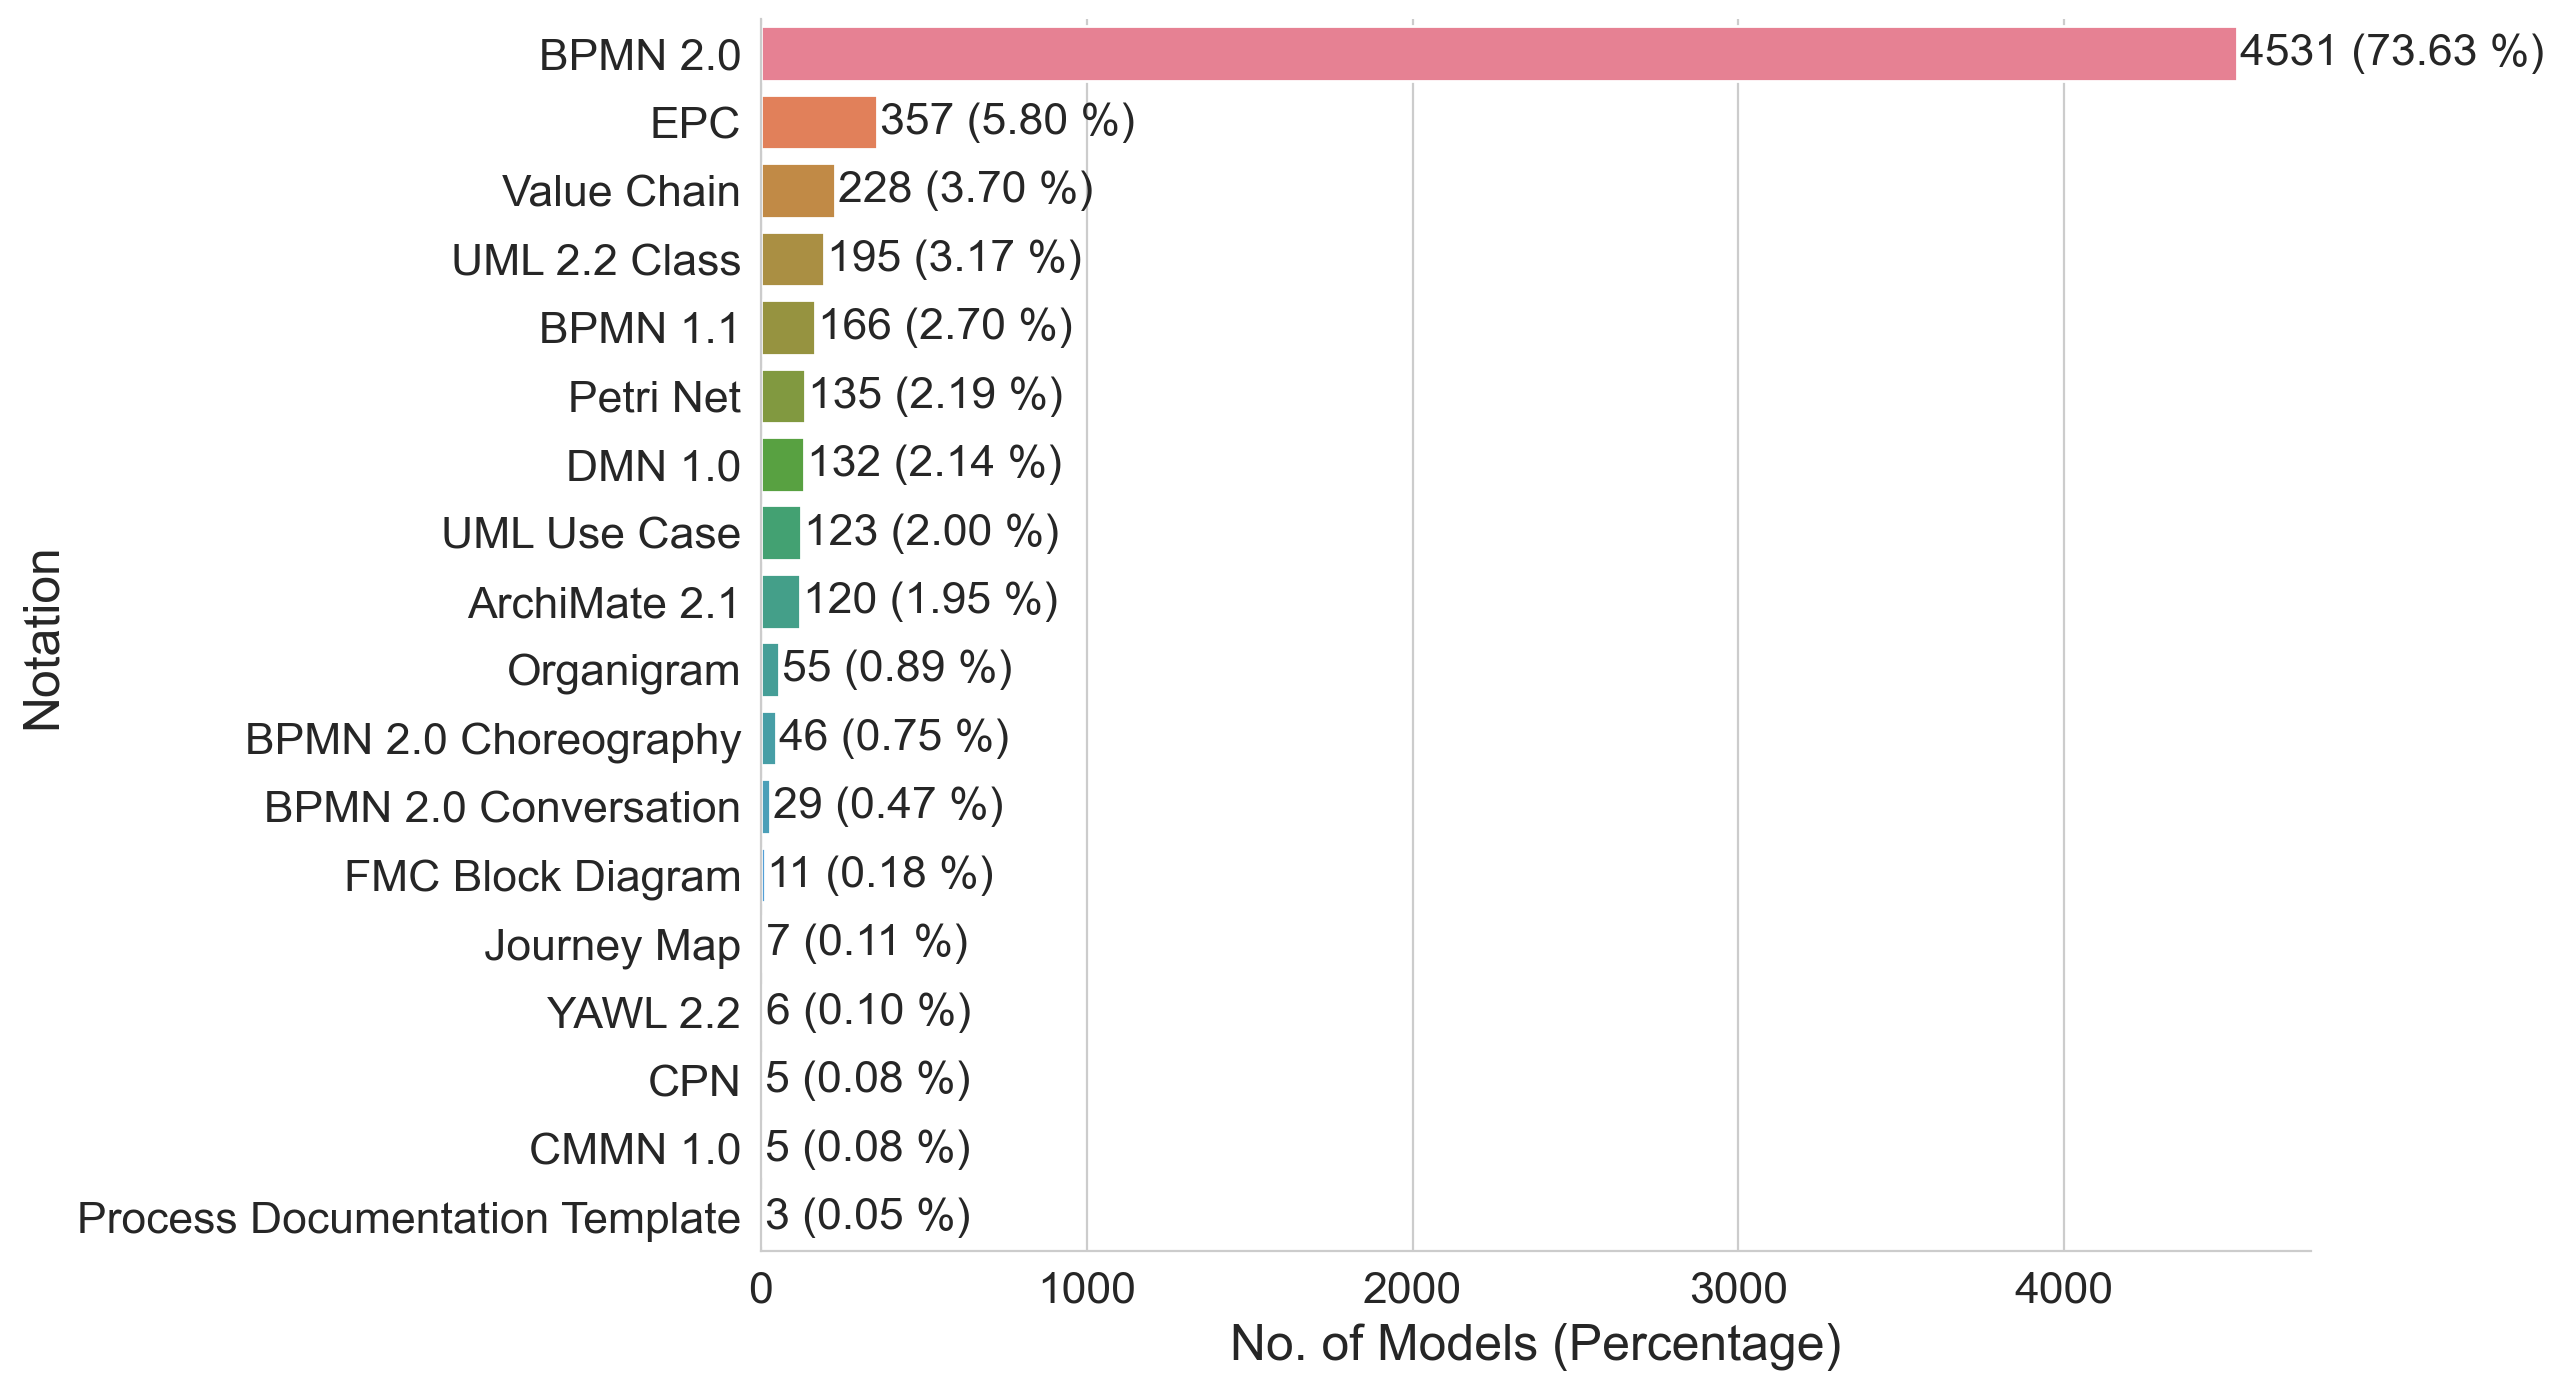

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
#ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
c1f9781d06594f068bee14f96d6744f3,43fe80a91c114d3ca121e8e8fb03a0a6,c78f482cc9d54a278154a3d1671450db,2011-12-01 23:11:10,NaN,Ampel - Lösung 1,Petrinets,http://b3mn.org/stencilset/petrinet#


In [20]:
df_meta.sort_values('datetime').tail(1)

,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
c32c4d43c1a3473d8db670c3739bbb97,b72919cca2154cb5aba499254e0bd2b1,8f45cdba3d7c4c1b814f1ab1a883e289,2021-09-22 02:56:10,NaN,LABORATORIO 6B,NaN,http://b3mn.org/stencilset/bpmn2.0#


Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

,Notation,Frequency
0,http://b3mn.org/stencilset/bpmn2.0#,4531
1,http://b3mn.org/stencilset/epc#,357
2,http://www.signavio.com/stencilsets/processmap#,228
3,http://b3mn.org/stencilset/UML2.2Class#,195
4,http://b3mn.org/stencilset/bpmn1.1#,166


In [22]:
#handling the case where we have unknown namespaces in the dataset
#to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

,namespace,Count,Year
0,UML 2.2 Class,2,2015
1,UML 2.2 Class,18,2016
2,UML 2.2 Class,22,2017
3,UML 2.2 Class,24,2018
4,UML 2.2 Class,11,2019
5,UML 2.2 Class,55,2020
6,UML 2.2 Class,63,2021
7,BPMN 1.1,3,2015
8,BPMN 1.1,7,2016
9,BPMN 1.1,14,2017


Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

1

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
#df_meta_selected.head()
df_meta_selected

,namespace,Count,Year
0,UML 2.2 Class,2,2015
1,UML 2.2 Class,18,2016
2,UML 2.2 Class,22,2017
3,UML 2.2 Class,24,2018
4,UML 2.2 Class,11,2019
5,UML 2.2 Class,55,2020
6,UML 2.2 Class,63,2021
7,BPMN 1.1,3,2015
8,BPMN 1.1,7,2016
9,BPMN 1.1,14,2017


In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

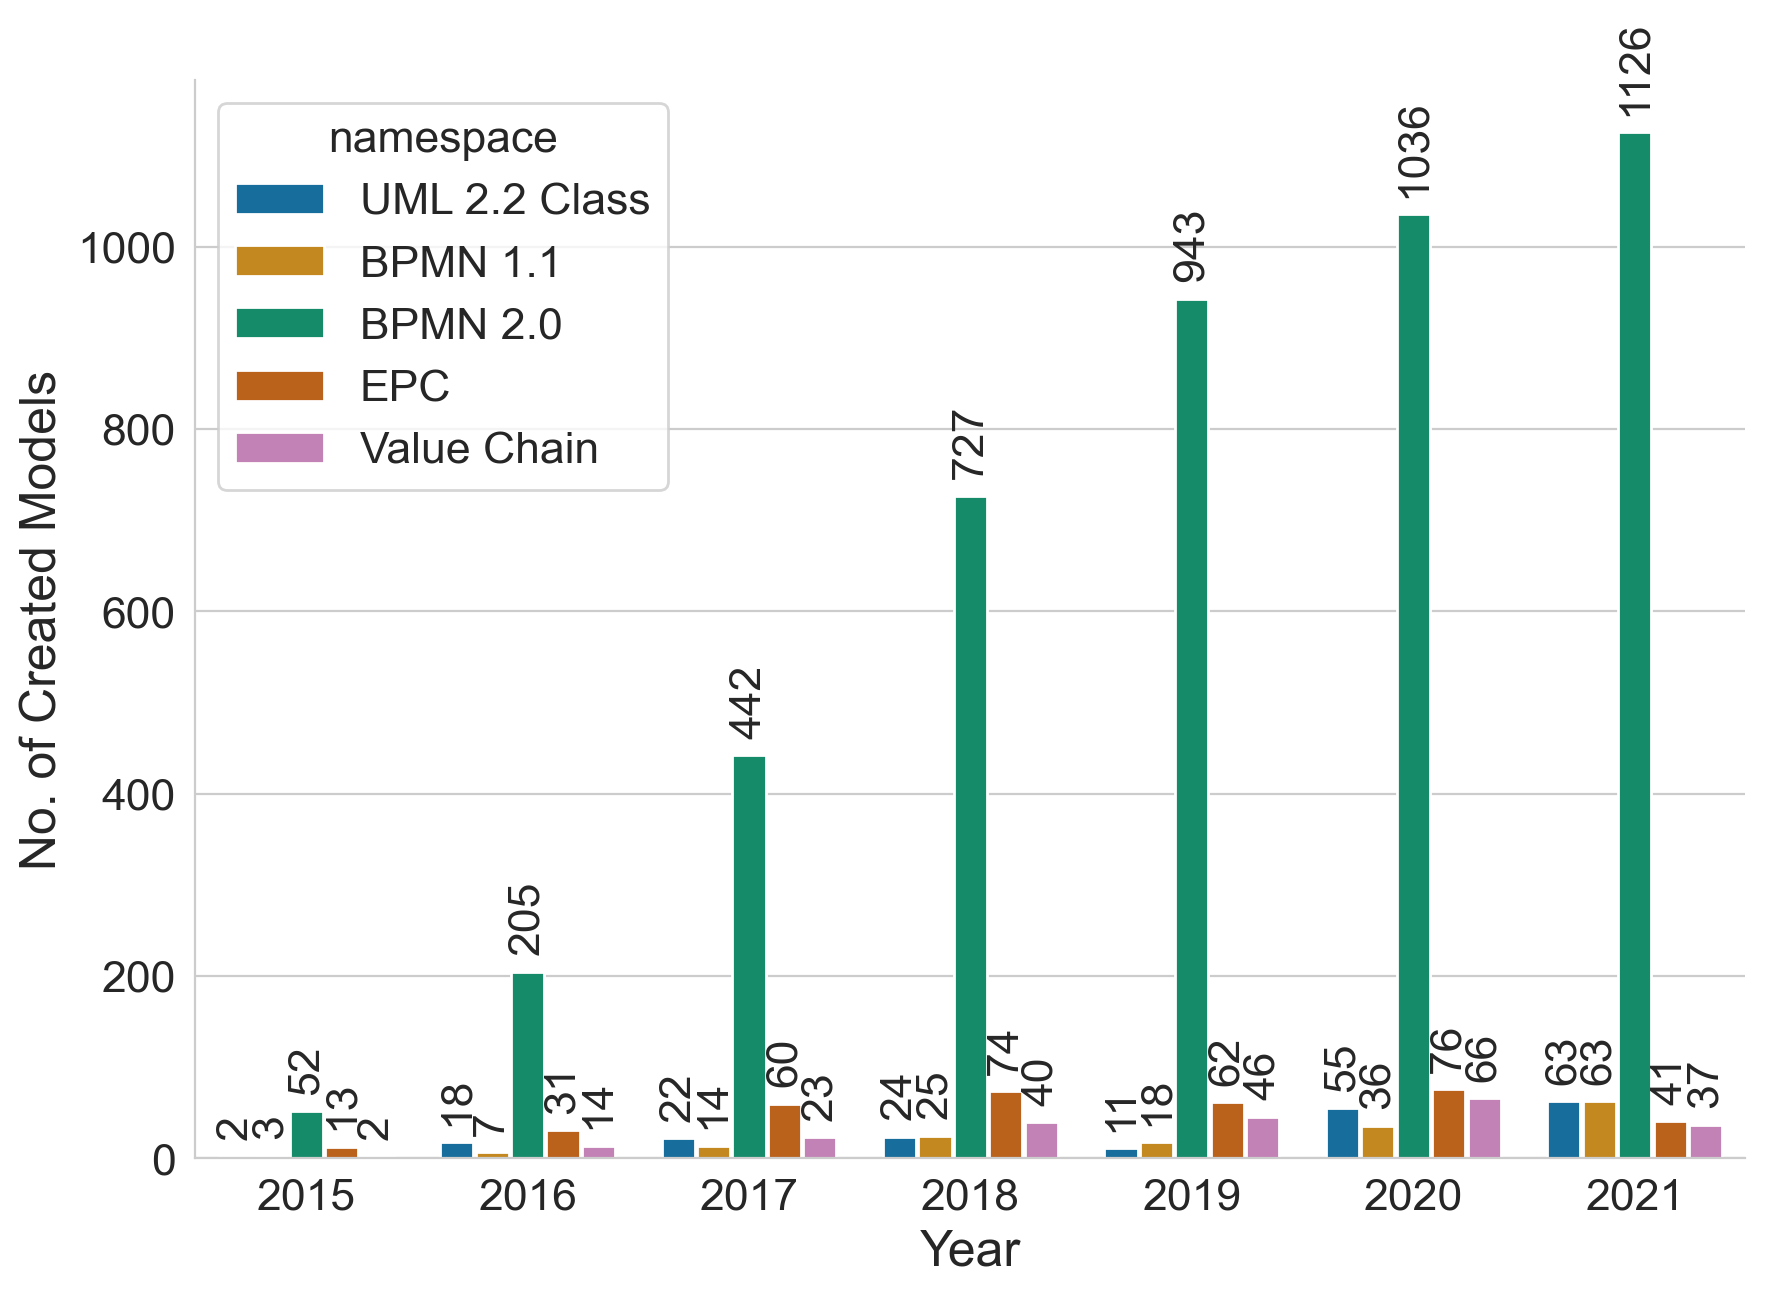

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

,BPMN 2.0,EPC,Value Chain,UML 2.2 Class,BPMN 1.1
2021,1126,41,37,63,63
2020,1036,76,66,55,36
2019,943,62,46,11,18
2018,727,74,40,24,25
2017,442,60,23,22,14
2016,205,31,14,18,7
2015,52,13,2,2,3


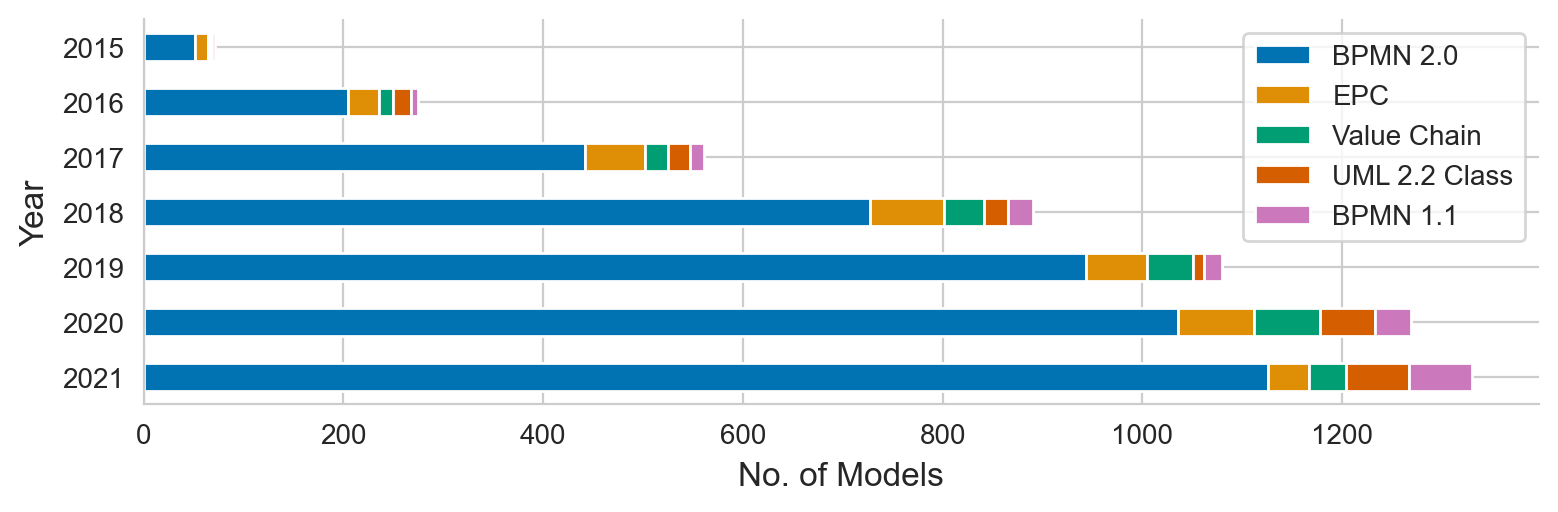

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

,revision_id,organization_id,datetime,description,name,type,namespace
model_id,,,,,,,
0c4a4701a6524166adaab25fb9e06374,24280a31d8a045aebdbd69b996a848b7,c41660388a04449a995dccf97d894f46,2021-08-14 17:19:56,NaN,12345678,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a6e19f392466c9f5ea34f0753397d,cb8a1351a515467b822fae0cf0b527df,ea6228bbe6f14163a04b3d115bae768b,2021-04-03 17:01:03,NaN,homework1,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a80580f0143c691ea5bbbb1f42ba1,188fc2f3e52b429bbda22f12bfb01edc,a54008f9eb7b45129caa83592542548a,2017-07-02 19:11:17,NaN,Jane Doe:Unterprozess:Auszahlung veranlassen,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4a8a87a5074bf0ac488fb15d9ff828,8c20371e944b4833a3176257acf0c0f4,91ad7bac45a2491bb32721669ad5790a,2019-11-27 19:58:35,NaN,Aufgabe4_Jane Doe,NaN,http://b3mn.org/stencilset/bpmn2.0#
0c4aa1c91ff9451d89c2a6f69632e2ff,b1bf293fe4bd40d491f1e9096a1c8b4f,cbc6a3654f3649a2b05410f0ffabda2c,2020-05-02 15:43:04,NaN,A1.2-2 - CORRECTION,BPMN 2.0,http://b3mn.org/stencilset/bpmn2.0#


Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

4531

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [ ]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]

Number of BPMN 2.0 models from the parser:

In [ ]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

Number of BPMN 2.0 models from the parser after filtering out example processes:

In [ ]:
df_bpmn = DataFilter(df_bpmn)
df_bpmn.filter_data("models", 1)
df_bpmn = df_bpmn.dataset
index = df_bpmn.index.get_level_values('model_id')
index.nunique()
df_bpmn = DataFilter(df_bpmn)
df_bpmn.filter_data("example_processes")
df_bpmn = df_bpmn.dataset
index = df_bpmn.index.get_level_values('model_id')
index.nunique()
df_bpmn.head()

When compared to the analysis of the dataset metadata, we notice the count of BPMN 2.0 models is slightly lower. This difference shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements, and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [ ]:
len(df_bpmn)

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [ ]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

In [ ]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

Let's plot the use of different languages across the dataset.

In [ ]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [ ]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

We only plot the 10 most common languages.

In [ ]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [ ]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [ ]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

These are the statistics of the different element types per model:

In [ ]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [ ]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

In [ ]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [ ]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1]
df_freq

In [ ]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

In [ ]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
else:
    ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [ ]:
df_bpmn.head()

First, we calculate and visualize the total counts of business objects in the dataset.

In [ ]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [ ]:
total_bos_count = len(total_bos)
total_bos_count

In [ ]:
len(df_bpmn)

When compared to the total number of elements, that would be about:

In [ ]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

Next, let's take a look at how many models have at least one glossary link.

In [ ]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [ ]:
len(models_w_bos)

The highest number of glossary links used in one model:

In [ ]:
models_w_bos.max()

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [ ]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

In [ ]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

In [ ]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown, maybe pandas v2 is necessary?
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
else:
    ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [ ]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [ ]:
len(its_bos_count)

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [ ]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

In [ ]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind"),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [ ]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

In [ ]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind"),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [ ]:
cnt_elements.total_count.describe()

These are the statistics of the number of elements per model by element type:

In [ ]:
cnt_elements.describe().transpose()

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [ ]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [ ]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

In [ ]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

In [ ]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [ ]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

In [ ]:
df_high_level.head()

The number of nodes and edges is naturally highly correlated:

In [ ]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [ ]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [ ]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

The number of distinct process names:

In [ ]:
len(cnts_names)

We use Signavio's color palette for the word cloud.

In [ ]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

In [ ]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [ ]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

The number of distinct element labels:

In [ ]:
len(cnts_labels)

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [ ]:
len(df_bpmn)

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [ ]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

... while 64.9 % of the labels are used for only one element.

In [ ]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

In [ ]:
len(cnts_labels[cnts_labels.occurrences==1])

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [ ]:
bins = cnts_labels
bins.head()

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [ ]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [ ]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

In [ ]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

In [ ]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()